In [907]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from arch import arch_model
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from scipy.stats import norm

# Simulación

In [979]:
mu =0
omega = 0.4
alpha = 0.4
beta = 0.3
sim_mod = arch_model(None, p=1, o=0, q=1,dist="normal")
params = {"mu":mu,"omega": omega,"alpha[1]":alpha,"beta[1]":beta}
param = pd.Series(params)

n=10000


In [980]:

datos_simulados = []
for i in range(n):
    np.random.seed(69)
    sim_data = sim_mod.simulate(param, 1000)
    datos_simulados.append(sim_data["errors"])


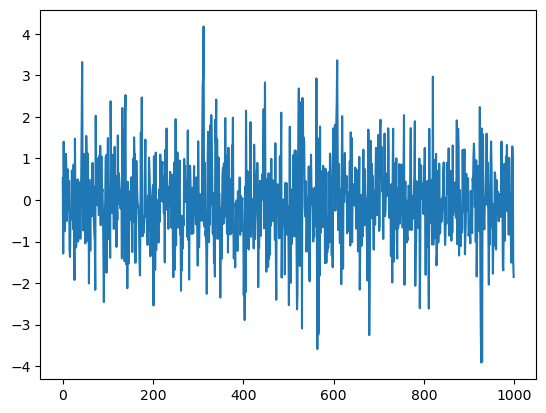

In [970]:
plt.plot(datos_simulados[20])

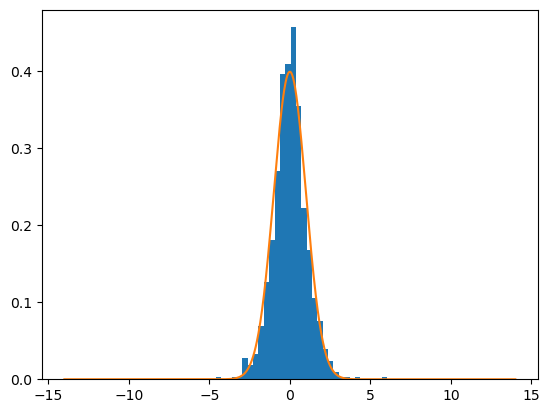

In [1032]:
plt.hist(datos_simulados[10],bins=32,density=True)
f_normal = lambda x : np.exp(-x**2/2)/np.sqrt(2*np.pi)
x = np.linspace(-14, 14, 1000)
plt.plot(x,f_normal(x));


# PACF y ACF

## ACF

In [958]:
def acf_garch(a,b,h):
    # h>=1
    p_1 = a*(1-b*(a+b))/(1-(a+b)**2+a**2) 
    p_h = p_1 *(a+b)**(h-1)
    return p_h
    

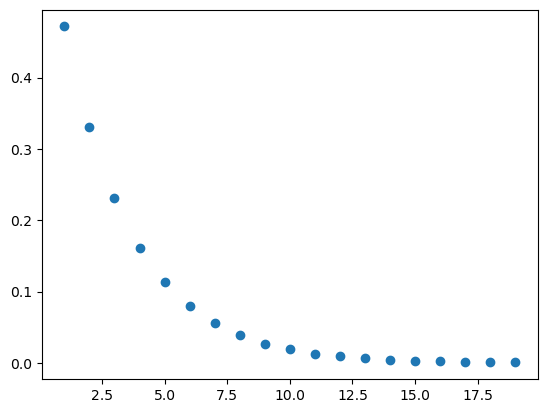

In [959]:
acf_teory = []
for i in range(1,20):
    acf_teory.append(acf_garch(alpha,beta,i))
    
x = np.arange(1,20)
plt.scatter(x,acf_teory);


In [960]:
acfs = []
for i in range(n):
    acfs.append(acf(datos_simulados[i]**2,nlags = 20))

In [961]:

df = pd.DataFrame(acfs, columns=np.arange(0, 21))
acf_mean = df.mean()
acf_mean[1:20]-acf_teory

1    -0.078133
2    -0.087876
3    -0.074327
4    -0.063788
5    -0.055388
6    -0.040895
7    -0.030438
8    -0.025237
9    -0.020774
10   -0.012650
11   -0.007310
12   -0.007080
13   -0.000011
14   -0.002938
15   -0.002847
16   -0.002133
17   -0.003068
18    0.001398
19    0.001810
dtype: float64

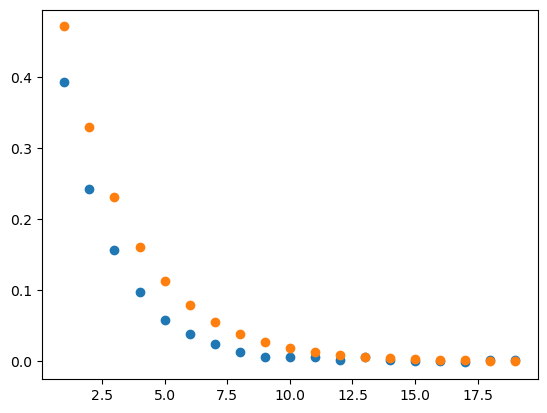

In [962]:
plt.scatter(x,acf_mean[1:20])
plt.scatter(x,acf_teory);

## PACF

In [943]:
def pacf_garch(corr,h):
    a = [1]
    for i in range(19):
        for j in range(19):
            print("nose")
            
    
    

# Ajuste

In [981]:
columns = ["mu","omega","alpha1","beta1"]
parametros = pd.DataFrame(columns=columns)
parametros
for i in range(n):
    modelo = arch_model(datos_simulados[i], p=1, o=0, q=1)
    res = modelo.fit(disp="off")
    new_row = pd.DataFrame([res.params.values], columns=columns)
    parametros = pd.concat([parametros,new_row], axis=0)
    
    

In [982]:
parametros.head()

,mu,omega,alpha1,beta1
0,-0.029269,0.514603,0.379254,0.181980
0,0.019967,0.392586,0.449671,0.261785
0,0.006281,0.356732,0.483219,0.279809
0,0.010156,0.582847,0.393013,0.168589
0,-0.008848,0.415936,0.361413,0.297983


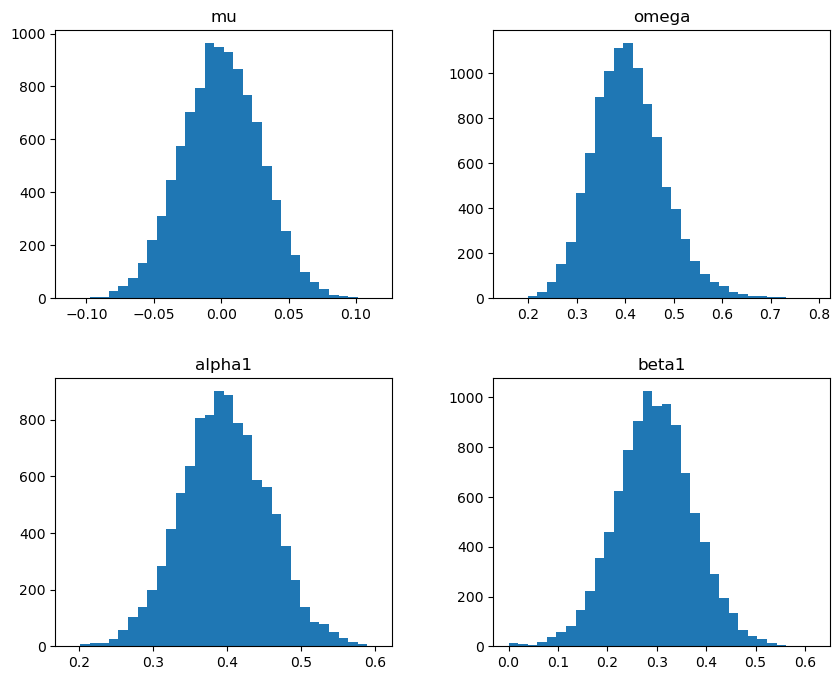

In [983]:
parametros.hist(figsize=(10, 8), grid = False,bins=32);

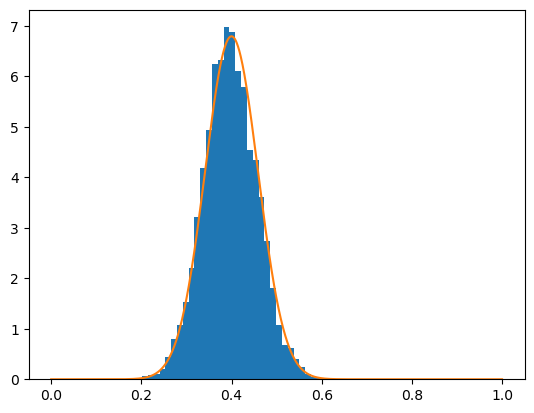

In [1166]:
plt.hist(parametros["alpha1"],bins=32,density=True);
f_normal = lambda x : np.exp(-(x-alpha)**2/(2*np.var(parametros["alpha1"],)))/np.sqrt(2*np.pi*np.var(parametros["alpha1"]))
x = np.linspace(0, 1, 1000)
plt.plot(x,f_normal(x));

In [986]:
parametros.mean()

mu       -0.000025
omega     0.406746
alpha1    0.397097
beta1     0.295578
dtype: float64

In [1162]:
parametros.var()

mu        0.000860
omega     0.005262
alpha1    0.003447
beta1     0.006190
dtype: float64

# Teorema 5.1

In [1086]:
acfs51 = []
for i in range(n):
    acfs51.append(acf(datos_simulados[i],nlags = 10))

In [1107]:
p1 = []
for i in range(len(acfs51)):
    p1.append(np.sqrt(len(datos_simulados[1]))*acfs51[i][2])

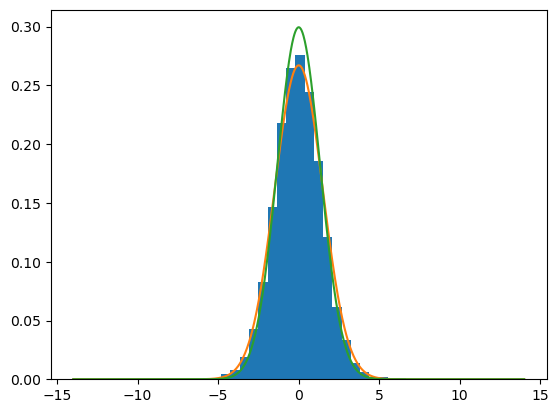

In [1169]:
plt.hist(p1,bins=32,density=True);
f_normal = lambda x : np.exp(-x**2/(2*np.var(p1)))/np.sqrt(2*np.pi*np.var(p1))
f_normal2 = lambda x : np.exp(-x**2/(2*final))/np.sqrt(2*np.pi*final)
x = np.linspace(-14, 14, 1000)
plt.plot(x,f_normal(x));
plt.plot(x,f_normal2(x));

In [1109]:
np.array(p1).var()

2.2312708542670605

In [1129]:
def varianza(omega,a,b,h):
    t1 = ((1+a+b)*(a+b)**h) / ((1-(a+b)**2-2*a**2)*(1-a-b))
    t2 = (1-(a+b)**h)/(1+a+b)**2
    return omega**2*(t1+t2)

In [1167]:
v = varianza(omega,alpha,beta,2)
sigma = omega/(1-alpha-beta)
final = v/sigma**2

In [1168]:
final

1.7748606811145513

In [ ]:
def cov(datos):
    suma =0
    n = len(datos)
    for i in range(n):
        suma = suma+ datos[i]**2
    return suma/n

In [1114]:
suma =0
for i in range(len(datos_simulados)):
    suma = suma + cov(datos_simulados[1])*acfs51[i][1]
suma = suma/len(datos_simulados)
suma/sigma

-0.000791728808039329